In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
nyc_pop = 8804190  #current population of NYC
covid_infections = pd.read_csv("covid_cases.csv")
covid_infections.head()

,extract_date,specimen_date,Number_tested,Number_confirmed,Number_hospitalized,Number_deaths
0,04/29/2020,04/17/2020,9979,3386,527,96
1,04/29/2020,02/08/2020,1,0,0,0
2,04/29/2020,03/05/2020,63,5,3,1
3,04/29/2020,04/09/2020,9019,4803,1253,386
4,04/29/2020,04/03/2020,9389,5523,1688,582


In [18]:


covid_infections['Date'] = pd.to_datetime(covid_infections['specimen_date'], format="%m/%d/%Y", errors = 'coerce')
covid_infections['specimen_month'] = covid_infections['specimen_date'].str[:2].apply(int)
covid_infections['specimen_year'] = covid_infections['specimen_date'].str[6:].apply(int)


covid_infections = covid_infections[(covid_infections['specimen_year'] == 2020) | (covid_infections['specimen_year'] == 2021)]

infect_by_month = covid_infections.groupby(['specimen_month', 'specimen_year']).agg({"Number_confirmed": "mean"})
infect_by_month['Number_confirmed'] = infect_by_month['Number_confirmed'].apply(lambda x: ( x / nyc_pop) * 100 )
infect_by_month.head()

Number_confirmed
specimen_month specimen_year                  
1              2020                   0.000019
               2021                   0.030547
2              2020                   0.000004
               2021                   0.019161
3              2020                   0.025139

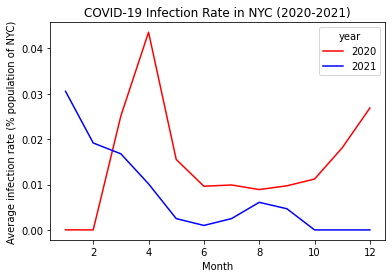

In [19]:
infect_2020 = infect_by_month.unstack()[('Number_confirmed', 2020)]
infect_2021 = infect_by_month.unstack()[('Number_confirmed', 2021)].fillna(0)


#bar plot for infection bar graphs
labels = [x for x in range(1, len(infect_2020) + 1)]
data = [
    infect_2020.tolist(),
    infect_2021.tolist()
]
combined_data = list(zip(data[0], labels, [2020 for x in range(len(infect_2020))])) \
                + list(zip(data[1], labels, [2021 for x in range(len(infect_2021))])
)
df = pd.DataFrame(combined_data, columns=["Average_Infections", "month", "year"])

sns.lineplot(x="month",y="Average_Infections", data=df, hue="year" , palette=["red", "blue"])
plt.title("COVID-19 Infection Rate in NYC (2020-2021)")
plt.xlabel("Month")
plt.ylabel("Average infection rate (% population of NYC)")
plt.show()

In [20]:
nyc_individual = pd.read_csv("nyc_individual_covid_data.csv")
nyc_individual['month'] = nyc_individual['case_month'].apply(lambda x: int(x[5:]))
nyc_individual['year'] = nyc_individual['case_month'].apply(lambda x: int(x[:4]))
nyc_individual['underlying_conditions_yn'].fillna("No", inplace=True)
nyc_individual.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,...,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn,month,year
0,2020-12,NY,36,BRONX,36005,0 - 17 years,Female,American Indian/Alaska Native,Hispanic/Latino,0.0,...,Missing,Missing,Probable Case,Symptomatic,Missing,Missing,Missing,No,12,2020
1,2021-01,NY,36,QUEENS,36081,0 - 17 years,Female,American Indian/Alaska Native,Hispanic/Latino,1.0,...,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Missing,No,1,2021
2,2021-01,NY,36,KINGS,36047,18 to 49 years,Female,American Indian/Alaska Native,Hispanic/Latino,1.0,...,Missing,Missing,Probable Case,Symptomatic,Missing,Missing,Missing,No,1,2021
3,2020-11,NY,36,RICHMOND,36085,18 to 49 years,Female,American Indian/Alaska Native,Hispanic/Latino,1.0,...,Missing,Missing,Probable Case,Symptomatic,Missing,Missing,Missing,No,11,2020
4,2020-12,NY,36,BRONX,36005,0 - 17 years,Female,American Indian/Alaska Native,Hispanic/Latino,NaN,...,Missing,Missing,Probable Case,Symptomatic,Missing,Missing,Missing,No,12,2020


In [21]:
expose_nyc_individual = pd.get_dummies(nyc_individual, columns=['exposure_yn'], drop_first=True)
expose_month_data = expose_nyc_individual.groupby(['month', 'year']).agg(
    infected = pd.NamedAgg("case_month", aggfunc="count") , # number of people infected
    exposed = pd.NamedAgg("exposure_yn_Yes", aggfunc="sum") #number of people infected due to exposure
).unstack().fillna(0)
expose_month_data['percent_exposed', 2020]= 100 * (expose_month_data['exposed'][2020]  / expose_month_data['infected'][2020])
expose_month_data['percent_exposed', 2021]= 100 * (expose_month_data['exposed'][2021]  / expose_month_data['infected'][2021])
expose_month_data.fillna(0, inplace=True)
expose_month_data.head()

infected           exposed         percent_exposed          
year      2020      2021    2020    2021            2020      2021
month                                                             
1         72.0  147254.0     1.0  1933.0        1.388889  1.312698
2        650.0   94683.0     9.0   728.0        1.384615  0.768881
3      58575.0  103035.0    21.0   787.0        0.035851  0.763818
4      99074.0   58679.0    14.0   765.0        0.014131  1.303703
5      24439.0   14372.0     6.0    57.0        0.024551  0.396605

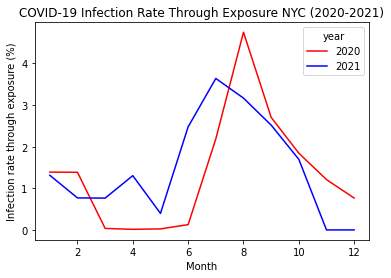

In [22]:
percent_exposed_2020 = expose_month_data['percent_exposed', 2020].tolist()
percent_exposed_2021 = expose_month_data['percent_exposed', 2021].tolist()
months = [x for x in range(1, len(percent_exposed_2020) + 1)]

combined_data = list(zip(percent_exposed_2020, months, [2020 for x in range(1, len(percent_exposed_2020) + 1)])) + \
                list(zip(percent_exposed_2021, months, [2021 for x in range(1, len(percent_exposed_2021) + 1)]))

df = pd.DataFrame(combined_data, columns=["percent_infected_exposed", "month", "year"])
sns.lineplot(x="month", y = "percent_infected_exposed", hue = "year", data=df, palette=["red", "blue"])
plt.title("COVID-19 Infection Rate Through Exposure NYC (2020-2021)")
plt.xlabel("Month")
plt.ylabel("Infection rate through exposure (%)")
plt.show()

In [23]:
infect_by_day = covid_infections.groupby(['Date']).agg({"Number_confirmed": "mean"}).apply(lambda x: ( x / nyc_pop) * 100 )
infect_by_day.head()

,Number_confirmed
Date,
2020-01-01,0.000014
2020-01-02,0.000024
2020-01-03,0.000043
2020-01-04,0.000050
2020-01-05,0.000095


In [24]:
covid_vaccine_nyc = pd.read_csv("nyc_vaccine.csv")
covid_vaccine_nyc.dropna(inplace=True)
covid_vaccine_nyc.head()

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Series_Complete_Pop_Pct,Series_Complete_Yes,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,...,SVI_CTGY,Series_Complete_Pop_Pct_SVI,Series_Complete_12PlusPop_Pct_SVI,Series_Complete_18PlusPop_Pct_SVI,Series_Complete_65PlusPop_Pct_SVI,Metro_status,Series_Complete_Pop_Pct_UR_Equity,Series_Complete_12PlusPop_Pct_UR_Equity,Series_Complete_18PlusPop_Pct_UR_Equity,Series_Complete_65PlusPop_Pct_UR_Equity
0,11/16/2021,36047,46,Kings County,NY,61.1,1564315,1564160,72.6,1467479,...,D,16.0,16.0,16.0,16.0,Metro,4.0,4.0,4.0,4.0
1,11/16/2021,36061,46,New York County,NY,74.9,1219561,1219437,83.3,1162992,...,C,12.0,12.0,12.0,12.0,Metro,4.0,4.0,4.0,4.0
2,11/16/2021,36005,46,Bronx County,NY,62.6,887632,887553,75.2,816533,...,D,16.0,16.0,16.0,16.0,Metro,4.0,4.0,4.0,4.0
3,11/16/2021,36085,46,Richmond County,NY,64.3,306292,306260,74.9,285961,...,B,8.0,8.0,8.0,8.0,Metro,4.0,4.0,4.0,4.0
4,11/16/2021,36081,46,Queens County,NY,75.1,1693016,1692929,87.1,1578493,...,C,12.0,12.0,12.0,12.0,Metro,4.0,4.0,4.0,4.0


In [25]:
covid_vaccine_nyc['Date'] = pd.to_datetime(covid_vaccine_nyc['Date'], format="%m/%d/%Y")
vax_per_day = covid_vaccine_nyc.groupby(['Date']).agg({"Series_Complete_Pop_Pct": "mean"})
vax_per_day.head()


,Series_Complete_Pop_Pct
Date,
2021-01-08,0.150000
2021-01-09,0.166667
2021-01-10,0.200000
2021-01-11,0.233333
2021-01-12,0.240000


In [26]:
joined_data = vax_per_day.merge(infect_by_day, how ="left" ,on = "Date")
joined_data = joined_data[joined_data['Series_Complete_Pop_Pct'] > 0]
joined_data.dropna(inplace=True)
joined_data.head()


,Series_Complete_Pop_Pct,Number_confirmed
Date,,
2021-01-08,0.150000,0.038311
2021-01-09,0.166667,0.026771
2021-01-10,0.200000,0.022545
2021-01-11,0.233333,0.040342
2021-01-12,0.240000,0.036868


In [27]:
vax_rate = joined_data['Series_Complete_Pop_Pct'].to_list()
infection_rate = joined_data['Number_confirmed'].to_list()


the r2 score for this curve fitting is 0.8149974762342455


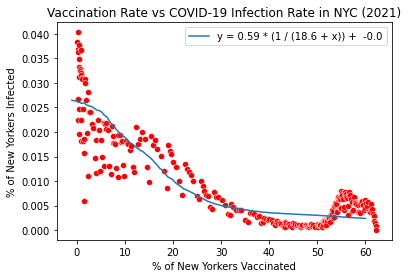

In [28]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

random_state = 40
x_train, x_test, y_train, y_test = train_test_split(vax_rate, infection_rate, test_size=0.7, random_state = random_state)
def func(x, a, b,c):
    return a * (1 / (b + x)) + c;

[a, b, c] , params_covar = curve_fit(func,x_train, y_train)


values = [func(x, a, b, c) for x in x_test];
print(f"the r2 score for this curve fitting is {r2_score(y_test, values)}")
    
y_pred = [func(x, a, b, c) for x in vax_rate];
myline = np.linspace(-1, 60, len(vax_rate))
plt.plot(myline, y_pred, label = f"y = {np.round(a, decimals=2)} * (1 / ({np.round(b, decimals=2)} + x)) +  {np.round(c, decimals=2)}")
sns.scatterplot(x=vax_rate, y=infection_rate, color= "red")
plt.title("Vaccination Rate vs COVID-19 Infection Rate in NYC (2021)")
plt.xlabel("% of New Yorkers Vaccinated")
plt.ylabel("% of New Yorkers Infected")
plt.show()